# Least Square Fit

The purpose of this notebook is to illustrate the method of applying that matrix inverse to input data is an efficient way of fitting parameters.

In [1]:
import numpy as np
import scipy as sp
import time
import scipy.linalg
import scipy.optimize
import matplotlib.pyplot as plt

#begin declaring primary functions (matrix squareroot and a check function)
def matrixsqrt(V, label="0", returntime=False):
    start = time.time()
    N = len(V[0])
    wt = np.empty([N,N]) #square root matrix (transposed)
    logdet = 0.
    #extracts eigenvalues and eigenvectors (bottleneck!)
    eigs, eigvecs = sp.linalg.eigh(V)
    for i in range(N):
        #sets each column in our transposed square root to the eigenvalue scaled by 1/sqrt(eig)
        wt[:,i] = (1./np.sqrt(eigs[i])) * eigvecs[:,i]
        logdet += np.log(2 * np.pi * eigs[i])
        #transposes the result
    w = np.ndarray.transpose(wt)
    end = time.time()
    dt = end-start
    if(label!="0"):
        print("Time elapsed for " + label + " is: " + str(dt) + "s")
    if(returntime==True):
        return w, logdet, dt
    else:
        return w, logdet

def ismsqrt(w,V):
    N = len(V[0])
    if(np.allclose(np.dot(V, np.dot(np.ndarray.transpose(w), w)),np.identity(N))):
        return True
    else:
        return False
    
#variance matrix generators
def makeV2(N, sigmarange=[100,300]):
    sigma2 = np.random.rand(N)*(sigmarange[1]-sigmarange[0]) + sigmarange[0]
    V2 = sigma2 * np.identity(N)
    return V2

def makeV3(N, sigmarange=[100,300], A=300, tau=30):
    K = np.empty([N,N])
    t = np.arange(N, dtype='int')
    for i in range(N):
        for j in range(N):
            K[i][j] = A * np.exp(-0.5 * (t[i]-t[j])**2 / (tau **2))
    V3 = makeV2(N, sigmarange=sigmarange) + K
    return V3

def makeV4(N, I, A=300, tau=30):
    V = np.empty([N,N])
    V = 0*V
    K = np.empty([N,N])
    t = np.arange(N, dtype='int')
    for i in range(N):
        for j in range(N):
            K[i][j] = A * np.exp(-0.5 * (t[i]-t[j])**2 / (tau **2))
            if(i==j):
                V[i][j]=np.sqrt(I[i] + 10000)
    V4 = V + K
    return V4

#importing preferred model
def expf(x, a, b):
    return np.exp((a*(x-b)))

def linef(x, a, b):
    return a*x + b

def linef2 (x, x1, y1, x2, y2):
    m = (y2-y1)/(x2-x1)
    b = y2 - (m*x2)
    return ((m*x) + b)

def piecewise(x, params): # params are: xl, xr, a1, b1, a3, b3
        xl = params[0]
        xr = params[1]
        a1 = params[2]
        b1 = params[3]
        a3 = params[4]
        b3 = params[5]
        result = np.empty(len(x))
        for i in range(len(x)):
                if(x[i]<=xl):
                    result[i] = expf(x[i], a1, b1)
                elif (x[i]>xl and x[i]<=xr):
                    result[i] = linef2(x[i], xl, expf(xl,a1,b1), xr, expf(xr, a3, b3))
                elif (x[i]>xr):
                    result[i] = expf(x[i], a3, b3)
        return result


Let's see if we need to use $w$ or $w^T$:

In [2]:
#opening data
data1 = "/Users/chris/Documents/QPP/SolarFlareGPs/data/121022782_ctime_lc.txt"
t1, I1 = np.loadtxt(data1, unpack=True)

#from prior fit, estimations of piecewise function
params = [1100, 1500, 1.3e-2, 100, -9e-3, 9200]

#check to use w over wT:
def checkw(params, I, t):
    V = makeV3(len(t))
    w, logdet = matrixsqrt(V)
    model = piecewise(t, params)
    resid = np.dot(w, (I - model))
    chisq = np.dot(resid, resid)
    resid2 = (I-model)
    Vinv = np.linalg.inv(V)
    chisq2 = np.dot(resid2, np.dot(Vinv,resid2))
    print chisq
    print chisq2
    print (chisq-chisq2)

#checkw(params, I1, t1)
#w is correct



In [8]:
#define residual function, using
def residualPW(params, w, I, t):
    model = piecewise(t, params)
    return np.dot(w, (I - model))

def chisqterm(params, w, I, t):
    chisqrt = residualPW(params, w, I, t)
    return np.dot(np.ndarray.transpose(chisqrt), chisqrt)
#values from later fit  
A0 = 44.48325411e+07
tau0 = 1.36841695e+00



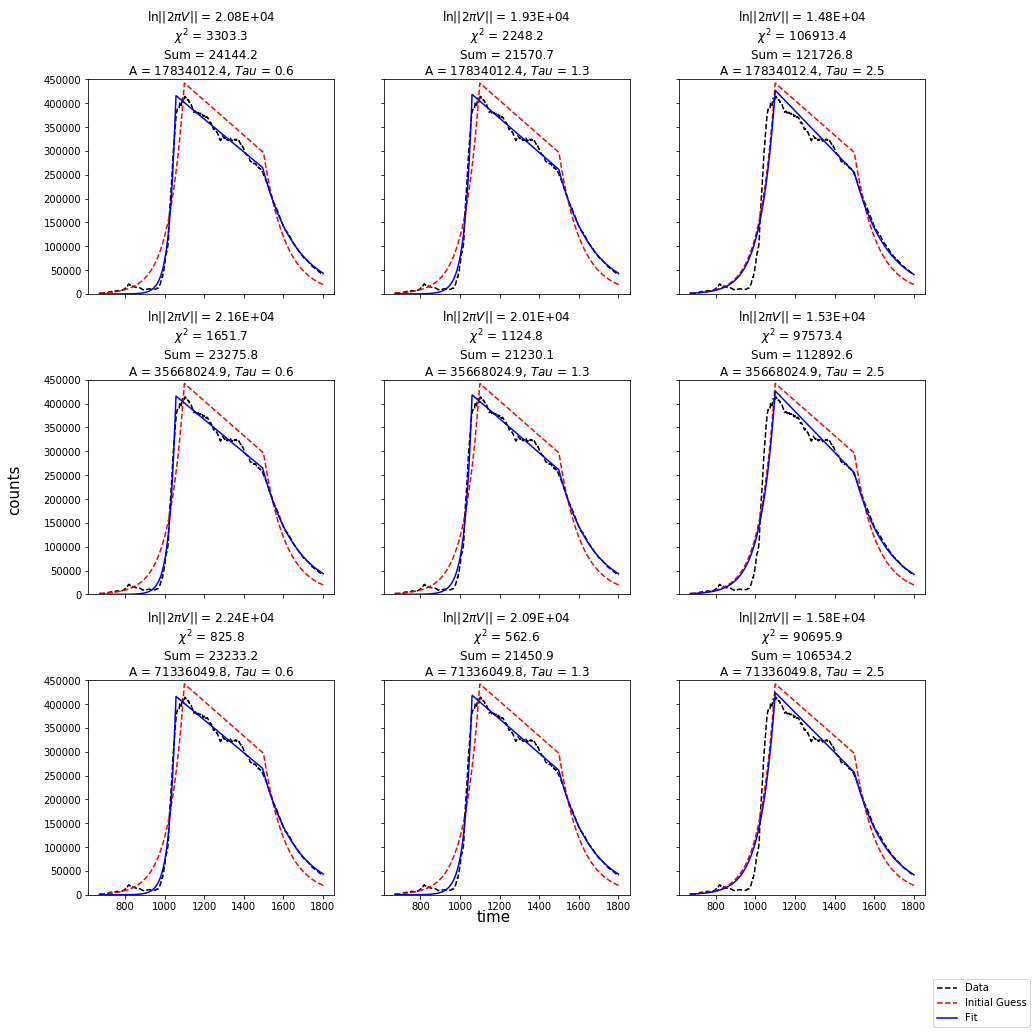

In [4]:
A = [A0/2, A0, A0 * 2]
tau = [tau0/2, tau0, tau0 * 2]
N = len(A) * len(tau)
w = np.empty([N, len(I1), len(I1)])
chisq = np.empty(N)
logdet = np.empty(N)
opt = np.empty([N,6])
#testing with various parameters
Iinit = piecewise(t1, params)


f, ax = plt.subplots(len(A), len(tau), figsize=(15,15), sharex = True, sharey=True)
f.subplots_adjust(hspace=0.4)
plt.ylim(0,450000)
f.text(0.5, 0.1, 'time', ha='center', fontsize=15)
f.text(0.05, 0.5, 'counts', va='center', rotation='vertical', fontsize=15)


for i in range(N):
    x = len(A)
    y = len(tau)
    V = makeV4(len(I1), I1, A = A[i/x], tau=tau[i%y])
    w[i], logdet[i] = matrixsqrt(V)
    opt[i], flag = sp.optimize.leastsq(residualPW, params, args = (w[i], I1, t1))
    I = piecewise(t1, opt[i])
    chisq[i] = chisqterm(opt[i], w[i], I1, t1)
    data, = ax[i/x,i%y].plot(t1, I1, 'k--', label='Data')
    guess, = ax[i/x,i%y].plot(t1, Iinit,'r--', label='Initial Guess')
    fit, = ax[i/x,i%y].plot(t1, I, 'b-', label = 'Fit')
    ax[i/x,i%y].set_title("$\ln{||2 \pi V||}$ = " + "{:.2E}".format(logdet[i]) + "\n$\chi^2$ = " + "{:.1f}".format(chisq[i]) + "\nSum = {:.1f}".format(chisq[i]+logdet[i]) +'\nA = {:.1f}'.format(A[i/3]) + ", $Tau$ = {:.1f}".format((tau[i%3])), ha = 'center')
    if(i%y!=0):
        plt.setp(ax[i/3,i%3].get_yticklabels(), visible=False)
    if(i/x!=(len(A)-1)):
        plt.setp(ax[i/3,i%3].get_xticklabels(), visible=False)
plt.figlegend([data, guess, fit], ["Data", "Initial Guess", "Fit"], 'lower right')
plt.show()


In [ ]:
#function returns the chi-squared term plus the logdet given A and tau parameters
def minimizeme(paramsV, params, I, t):
    V = makeV3(len(t1), A = paramsV[0], tau = paramsV[1])
    w, logdet = matrixsqrt(V)
    opt, flag = sp.optimize.leastsq(residualPW, params, args = (w, I1, t1))
    chisq = chisqterm(opt, w, I1, t1)
    return chisq+logdet

optV = scipy.optimize.minimize(minimizeme, [A0, tau0], args=(opt[N/2], I1, t1), method='Nelder-Mead', options={'maxiter':500})
print optV
V = makeV3(len(I1), A = optV.x[0], tau=optV.x[1])
w, logdet = matrixsqrt(V)
optPW, flag = sp.optimize.leastsq(residualPW, params, args = (w, I1, t1))
I = piecewise(t1, optPW)

plt.plot(t1, I1, 'k--', label='Data')
plt.plot(t1, Iinit,'r--', label='Initial Guess')
plt.plot(t1, I, 'b-', label = 'Fit')
plt.show()

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log


In [ ]:
if i is a number in range(6)
 then push it up until it's A variable
    keep running
    and eventually it'll craosih
    Afihaowti''